### María Sofía Álvarez - Brenda Barahona - Álvaro Plata

<h1 align='center'>Proyecto 1: Analítica de textos</h1>

## Instalación de librerías
<b><font color='blue'>Importante:</font></b> Correr antes de ejecutar el notebook. Con una única vez que se corra, basta.

In [1]:
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install -U git+https://github.com/neomatrix369/nlp_profiler.git@master
#!pip install wordcloud
#!pip install contractions
#!pip install nltk
#!pip install inflect
#!pip install unicode
#!pip install stopwords

## Importación de librerías
Importamos las librerías necesarias para el desarrollo de este proyecto

In [2]:
# ESAI
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize
from nlp_profiler.core import apply_text_profiling
from sklearn.model_selection import train_test_split, GridSearchCV
# Para resampling
from sklearn.utils import resample 
import contractions
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from collections import Counter
import nltk
nltk.download('wordnet')
import inflect
import re
import unicodedata
import stopwords
from nltk.corpus import stopwords
import seaborn as sns


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\brend\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brend\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brend\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brend\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
%matplotlib inline

Las historias médicas describen las condiciones actuales de un paciente. Los médicos rutinariamente escanean docenas o cientos de historias clínicas en un solo día mientras hacen sus turnos en un hospital y deben resaltar la información relevante de ellos para poder determinar la enfermedad que padece un paciente. El objetivo de este proyecto es, a partir de dichas historias clínicas dadas por los médicos, crear una herramienta que ayude en la identificación del problema/enfermedad que un paciente padece. Se busca que las predicciones realizadas sean bastante precisas, pues los pacientes deben ser tratados acorde con la enfermedad que padecen. 

A continuación, se leerá el conjunto de datos correspondiente. Este incluye historias clínicas de varios pacientes, con la información más relevante de sus enfermedades reportada por los médicos. Asimismo, para cada paciente se tiene la enfermedad que padece. De acuerdo con el diccionario, esta puede ser cualquiera de las siguientes 5 categorías: 
1. Neoplasms (Neoplasias).
2. Digestive system diseases (Enfermedades del sistema digestivo).
3. Nervous system diseases (Enfermedades del sistema nervioso).
4. Cardiovascular diseases (Enfermedades cardiovasculares).
5. General pathological conditions (Condiciones patológicas generales).

Es posible ver que se tiene un problema de clasificación multiclase. 

---
## 1. Entendimiento del problema
Lo primero que hacemos es cargar las librerías y el conjunto de datos, con el fin de entender las particularidades del problema que estamos enfrentando.
### 1.1 Perfilamiento de los datos
Procedemos, entonces, a ver los datos suministrados.

In [4]:
diagnoses =pd.read_csv('ApoyoDiagnosticoEstudiante/medical_text_clasificacion.csv')

In [5]:
print("Tamaño del conjunto de datos:", len(diagnoses))
diagnoses.sample(5)

Tamaño del conjunto de datos: 12000


,medical_abstracts,problems_described
4810,Ductal carcinoma in situ with microinvasion. A...,1
1376,"Pneumomediastinum, pneumothorax and subcutaneo...",5
9178,Treatment of severe colitis in Behcet's syndro...,2
10592,Chronic diarrhea in essential mixed cryoglobul...,5
2644,Periurethral colonic-type polyp simulating ure...,5


Con esto, podemos ver una muestra de los datos. Aquí, nos damos cuenta que nuestro conjunto de datos consiste de dos columnas: "medical_abstracts", con las historias clínicas de los pacientes (escritas en inglés), y "problems_described", que es un número con la enfermedad padecida por el paciente, de acuerdo con lo descrito arriba y en concordancia con el diccionario.

Asimismo, vemos que tenemos 12000 historias clínicas.

In [6]:
print('Las categorías de las enfermedades son: {}'.format(sorted(diagnoses['problems_described'].unique())))

Las categorías de las enfermedades son: [1, 2, 3, 4, 5]


Lo primero que podemos revisar es si hay algún problema que no se encuentre en las categorías 1-5 definidas para las enfermedades. Como vemos, en este caso todas las categorías concuerdan con las definidas por el negocio. Asimismo, nos damos cuenta que la clasificación es multiclase y no multietiqueta: cada historia clínica tiene una única enfermedad asociada.

Ahora queremos ver si nuestro conjunto de datos tiene entradas nulas. Para ello, revisamos si hay historias clínicas que correspondan con la cadena vacía "" o con un sólo espacio " ". Se ve que no hay ninguna con estas características, pues obtenemos un <i>dataframe</i> vacío, como vemos en la celda a continuación. Podemos hacer también una revisión con el método <code>isna()</code> de <code>pandas</code>. Este indica si hay algún valor de los datos que tenga como valor <code>None</code> o <code>numpy.NaN</code>. Vemos entonces que nuestro conjunto de datos no tiene ni nulos, ni faltantes.

In [7]:
print(diagnoses.isna().sum())

medical_abstracts     0
problems_described    0
dtype: int64


In [8]:
vacias = diagnoses[(diagnoses['medical_abstracts'] == "") | (diagnoses['medical_abstracts'] == " ")]
print('La cantidad de de historias clínicas vacías es: {}'.format(len(vacias)))

La cantidad de de historias clínicas vacías es: 0


Asimismo, confirmamos que no hay historias clínicas duplicadas en el conjunto de datos:

In [9]:
duplicados = diagnoses[diagnoses.duplicated()]
print('Número de registros duplicados: {}'.format(len(duplicados)))

Número de registros duplicados: 0


Vemos entonces que la calidad de los datos, en el sentido de nulos y duplicados, es bastante buena.



Es importante notar que almacenaremos el resultado del perfilamiento en un archivo <code>csv</code> para fácil acceso cuando tenga que ejecutarse todo el proyecto; y, segundo, nos enfocaremos en analizar únicamente aquellas funcionalidades de <code>nlp profiler</code> que sean relevantes para este proyecto. Entonces:

In [10]:
# Importante: ¡Esta celda tarda mucho en ejecutarse!
#profile_data = apply_text_profiling(diagnoses, 'medical_abstracts')

# Importante: No correr esta linea si no se ha corrido la anterior.
#profile_data.to_csv('nlp_profiler_medical_abstracts.csv', index=False)

In [11]:
#profile_data = pd.read_csv('nlp_profiler_medical_abstracts.csv')

## Preparación de datos

Nos damos cuenta ahora de que sólo tenemos una variable explicativa (la historia clínica) y que la variable objetivo (target) es la enfermedad que padece el usuario. Así las cosas partimos el conjunto de datos entre los datos de entrenamiento y de test: esto es crucial, pues, tras entrenar el modelo, debemos validarlo con datos que este nunca había visto. De acuerdo con el libro de Géron <a href='#geron'>[1]</a>, una buena división entre datos de entrenamiento y test es 80% y 20%, respectivamente, y en consecuencia es la que usaremos para toda esta exploración.

In [12]:
X, Y = diagnoses['medical_abstracts'], diagnoses['problems_described']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y,test_size=0.2, random_state=28)

Con esto, procedemos a hacer todo el entrenamiento sobre el conjunto de $X_{\mathrm{train}},Y_{\mathrm{train}}$ y guardamos el test en la "caja fuerte" hasta que sea el momento de la validación.

Queremos ver la distribución de las clases de nuestro conjunto de datos. Para ello, consideremos el siguiente histograma y la distribución de los textos de acuerdo con sus clases:

### Balanceo de clases

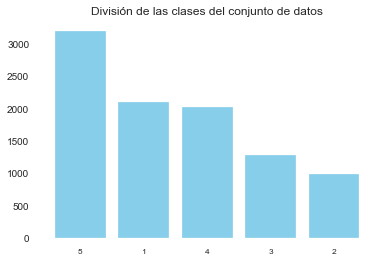

Veamos la cantidad de datos en cada clase: 


,problems_described
5,3194
1,2103
4,2029
3,1280
2,994


In [13]:
val_counts_y = Y_train.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='skyblue')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

print('Veamos la cantidad de datos en cada clase: ')
Y_train.value_counts().to_frame()

Podemos ver claramente que las clases están notablemente desbalanceadas. Vemos que la clase con más datos es la 5, lo cual es consecuente con el hecho de que esta es la clase más amplia, al tratar condiciones patológicas generales. Debemos clasificar todas las clases igual de bien, pues nos interesa conocer con precisión qué enfermedad posee cada paciente particular. Por esta razón, debemos utilizar técnicas de balanceo de clases. Podemos abordar este problema desde el preprocesamiento, probaremos realizando un submuestreo de los datos, **usando técnicas de oversampling como SMOTE (tambien intentamos este?)**, o en la implementación del algoritmo, diciéndole que estamos trabajando con clases desbalanceadas (aunque esto depende de los algoritmos a utilizar, los cuales se definirán más adelante). Quisiéramos ver ambos comportamientos, entonces intentaremos explorar ambas alternativas. Esto se realiza más adelante, en las secciones de preprocesamiento y modelado (respectivamente) de este documento.

Por lo dicho anteriormente, realizaremos un balanceo de datos, en el que quitaremos datos de los problemas 1, 4 y 5 

In [14]:
#Como vamos a cortar los datos, necesitamos tanto x como y unidos
data_train= pd.concat( [Y_train, X_train], axis=1)
data_train

,problems_described,medical_abstracts
5659,4,Placebo controlled trial of xamoterol versus d...
11557,1,Significance of blasts in low-cell-count cereb...
1509,5,Obstructive sleep apnea following topical orop...
6883,5,Experience with the Sarns centrifugal pump as ...
3844,3,Fine surface structure of an intraspinal neure...
...,...,...
5271,1,Chondrosarcoma of the soft tissues. Two differ...
11269,4,Prolongation of ventricular refractoriness by ...
2059,1,Regressing atypical histiocytosis. Aberrant pr...
8440,2,The role of gastric resection in the managemen...


In [15]:
cat1 = data_train[data_train["problems_described"] == 1]
cat2 = data_train[data_train["problems_described"] == 2]
cat3 = data_train[data_train["problems_described"] == 3]
cat4 = data_train[data_train["problems_described"] == 4]
cat5 = data_train[data_train["problems_described"] == 5]

cat1 = resample(cat1, replace = False, n_samples = 1000, random_state = 0)
cat4 = resample(cat4, replace = False, n_samples = 1000, random_state = 0)
cat5 = resample(cat5, replace = False, n_samples = 1000, random_state = 0)

data_train = pd.concat([cat1, cat2, cat3, cat4, cat5])
#Se cuentan los valores de la variable target
data_train["problems_described"].value_counts().to_frame()


,problems_described
3,1280
4,1000
1,1000
5,1000
2,994


In [16]:
X_train, Y_train = data_train[['medical_abstracts']], data_train[['problems_described']]

### Tokenización
Despues de tener las clases balanceadas, realizamos todo el proceso de tokenizacion, donde manejaremos contracciones de las palabras y separaremos las palabras en una lista

In [17]:
#pasa de you're a you are 
X_train['medical_abstracts']=X_train['medical_abstracts'].apply(contractions.fix)

<ipython-input-17-92f63173aa9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['medical_abstracts']=X_train['medical_abstracts'].apply(contractions.fix)


In [18]:
#Se crea nueva columna con la lista de las palabras 
X_train["words"]=X_train['medical_abstracts'].apply(word_tokenize)

### Stemming y Lemmatization 
Aplicaremos tecnicas como "Stemming" y "Lemmatization" sobre la columna "medical_abstracts"

In [19]:
#Funciones de "Stemming" y "Lemmatization"
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [20]:
X_train["words"]=X_train["words"].apply(stem_and_lemmatize)

In [21]:
X_train

,medical_abstracts,words
7103,Ovarian myxoma. A study of two cases with long...,"[ov, myxom, ., a, study, of, two, cas, with, l..."
2269,Intraperitoneal yttrium-90-labeled monoclonal ...,"[intraperiton, yttrium-90-labeled, monoclon, a..."
11595,Chemical carcinogenesis: too many rodent carci...,"[chem, carcinogenes, :, too, many, rod, carcin..."
11019,Comparison of FRTL-5 cell growth in vitro with...,"[comparison, of, frtl-5, cel, grow, in, vitro,..."
791,Invasive lobular carcinoma: mammographic findi...,"[invas, lobul, carcinom, :, mammograph, find, ..."
...,...,...
6572,Stress and sudden death. The case of the long ...,"[stress, and, sud, dea, ., the, cas, of, the, ..."
2483,Acute deterioration of renal function associat...,"[acut, detery, of, ren, funct, assocy, with, e..."
4484,Catheterization of coronary artery bypass graf...,"[cathet, of, coron, artery, bypass, graft, fro..."
4668,The electrocardiogram in chronic obstructive p...,"[the, electrocardiogram, in, chronic, obstruct..."


### Manejo de Ruido 
En esta sección se quitará o modificará todo lo que se considere como ruido:

+ Caracteres no ascii
+ Se pasará de mayusculas a minusculas
+ Se eliminará la puntuación
+ Se reemplazarán los números
+ Se quitarán las palabras vacias (artículos, pronombres, preposiciones)

In [22]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
    

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [23]:
X_train["words"]=X_train["words"].apply(preprocessing)
X_train

,medical_abstracts,words
7103,Ovarian myxoma. A study of two cases with long...,"[ov, myxom, study, two, cas, longterm, followu..."
2269,Intraperitoneal yttrium-90-labeled monoclonal ...,"[intraperiton, yttrium90labeled, monoclon, ant..."
11595,Chemical carcinogenesis: too many rodent carci...,"[chem, carcinogenes, many, rod, carcinog, admi..."
11019,Comparison of FRTL-5 cell growth in vitro with...,"[comparison, frtl5, cel, grow, vitro, xenotran..."
791,Invasive lobular carcinoma: mammographic findi...,"[invas, lobul, carcinom, mammograph, find, 10y..."
...,...,...
6572,Stress and sudden death. The case of the long ...,"[stress, sud, dea, cas, long, qt, syndrom, idi..."
2483,Acute deterioration of renal function associat...,"[acut, detery, ren, funct, assocy, ent, hypero..."
4484,Catheterization of coronary artery bypass graf...,"[cathet, coron, artery, bypass, graft, descend..."
4668,The electrocardiogram in chronic obstructive p...,"[electrocardiogram, chronic, obstruct, pulmon,..."


Ahora, eliminaremos algunas palabras que no consideramos importantes o relevantes para el problema

In [24]:
train_copy= pd.concat( [Y_train, X_train], axis=1)

In [25]:
#X_train['words']=train_copy["words"]
#X_train['words']

7103     [ov, myxom, study, two, cas, longterm, followu...
2269     [intraperiton, yttrium90labeled, monoclon, ant...
11595    [chem, carcinogenes, many, rod, carcinog, admi...
11019    [comparison, frtl5, cel, grow, vitro, xenotran...
791      [invas, lobul, carcinom, mammograph, find, 10y...
                               ...                        
6572     [stress, sud, dea, cas, long, qt, syndrom, idi...
2483     [acut, detery, ren, funct, assocy, ent, hypero...
4484     [cathet, coron, artery, bypass, graft, descend...
4668     [electrocardiogram, chronic, obstruct, pulmon,...
5182     [react, ecc, cont, coron, stenos, paty, chroni...
Name: words, Length: 5274, dtype: object

In [26]:
#En una primera iteracion nos dimos cuenta que las palabras "paty", "patients" aparece frecuentemente en todas las enfermedades,
#estos serán eliminados por que no agregan información valiosa. 
banned = ["and","paty","patients","p","one","two","three","study","result"]
def remove_banned(words):
    """Remove banned words"""
    new_words = []
    for word in words:
        if word not in banned:
            new_words.append(word)
    return new_words

X_train['words'] = X_train['words'].apply(remove_banned)

Ya con la preparación de textos lista, exportaremos los datos en csv para facilitar su uso en los modelos. 

In [27]:
#Actualizacion de la columna words. se pone toda la lista a manera de str 
X_train['words'] = X_train['words'].apply(lambda x: ' '.join(map(str, x)))

In [28]:
data_train= pd.concat( [Y_train, X_train], axis=1)
data_test= pd.concat( [Y_test, X_test], axis=1)
data_train.to_csv("train_Data.csv")
data_test.to_csv("test_Data.csv")
data_train

,problems_described,medical_abstracts,words
7103,1,Ovarian myxoma. A study of two cases with long...,ov myxom cas longterm followup cas socalled ov...
2269,1,Intraperitoneal yttrium-90-labeled monoclonal ...,intraperiton yttrium90labeled monoclon antibod...
11595,1,Chemical carcinogenesis: too many rodent carci...,chem carcinogenes many rod carcinog admin chem...
11019,1,Comparison of FRTL-5 cell growth in vitro with...,comparison frtl5 cel grow vitro xenotranspl ce...
791,1,Invasive lobular carcinoma: mammographic findi...,invas lobul carcinom mammograph find 10year ex...
...,...,...,...
6572,5,Stress and sudden death. The case of the long ...,stress sud dea cas long qt syndrom idiopath lo...
2483,5,Acute deterioration of renal function associat...,acut detery ren funct assocy ent hyperoxalur e...
4484,5,Catheterization of coronary artery bypass graf...,cathet coron artery bypass graft descend aort ...
4668,5,The electrocardiogram in chronic obstructive p...,electrocardiogram chronic obstruct pulmon dise...


## Resultados de preprocesamiento : Visualización de palabras mas frecuentes 

Después de haber hecho la limpieza de los datos y antes de empezar con c/u de los modelos, veremos cuales son las palabras mas frecuentes según cada dianóstico

In [29]:
#los tokens (palabras) para un determinado problems_described se junten
#Junta todas las palabras con el problema #problems_described
def generate_docx(df, problems_described):
    """Gets a string of all text of a category"""
    mylist = df[df["problems_described"] == problems_described]["words"].tolist()
    mydocx = ''.join(mylist)
    return mydocx

In [30]:
#Da los 50 tokens mas comunes 
def extract_keywords(text, num = 50):
    """Gets a dictionary with the # of ocurrences of a word"""
    tokens = [token for token in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

In [31]:
doc1=generate_docx(data_train, 1)
doc2=generate_docx(data_train, 2)
doc3=generate_docx(data_train, 3)
doc4=generate_docx(data_train, 4)
doc5=generate_docx(data_train, 5)

In [32]:
key_words_1= extract_keywords(doc1)
key_words_2= extract_keywords(doc2)
key_words_3= extract_keywords(doc3)
key_words_4= extract_keywords(doc4)
key_words_5= extract_keywords(doc5)

In [33]:
# Plot
def plot_most_common_words(mydict, problems_described):
    df_01 = pd.DataFrame(mydict.items(),columns=["token","count"])
    plt.figure(figsize=(10,5))
    plt.title("Plot of {}".format(problems_described))
    sns.barplot(x = 'token', y="count", data = df_01)
    plt.xticks(rotation=90)
    plt.show()
    
def plot_wordcloud(docx):
    mywordcloud = WordCloud().generate(docx)
    plt.figure(figsize=(10,5))
    plt.imshow(mywordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

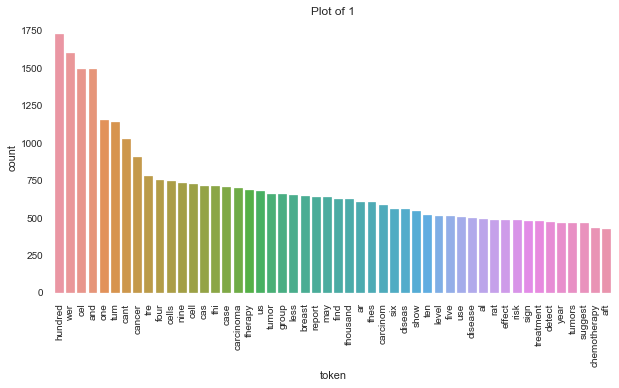

In [34]:
#1. Neoplasms
plot_most_common_words(key_words_1,"1")

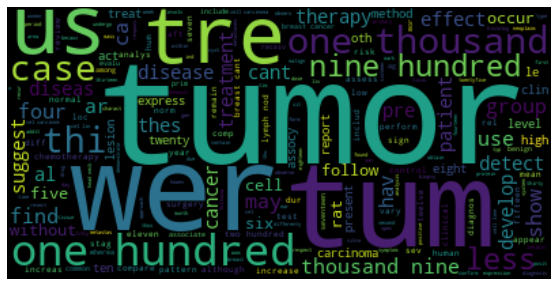

In [35]:
plot_wordcloud(doc1)

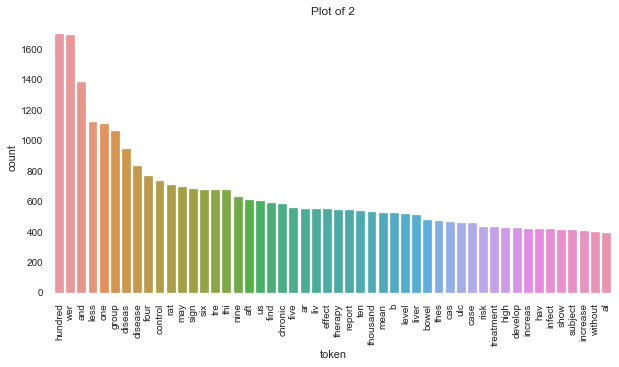

In [36]:
#2. Digestive system diseases
plot_most_common_words(key_words_2,"2")

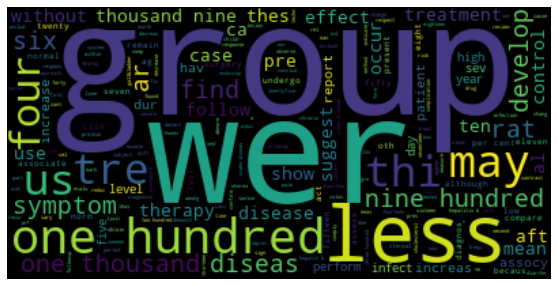

In [37]:
plot_wordcloud(doc2)

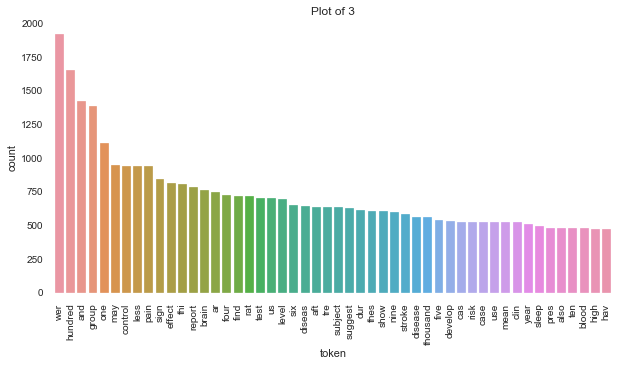

In [38]:
#3. Nervous system diseases
plot_most_common_words(key_words_3,"3")

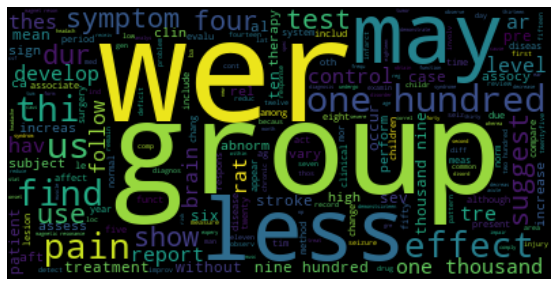

In [39]:
plot_wordcloud(doc3)

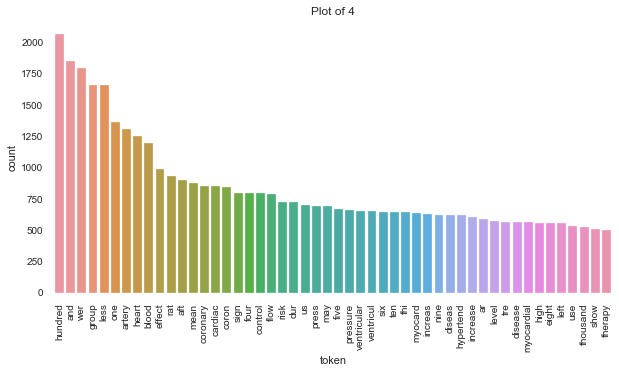

In [40]:
#4. Cardiovascular diseases
plot_most_common_words(key_words_4,"4")

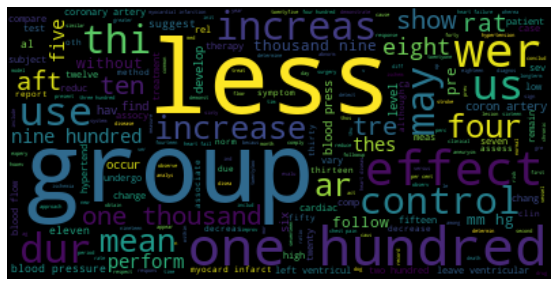

In [41]:
plot_wordcloud(doc4)

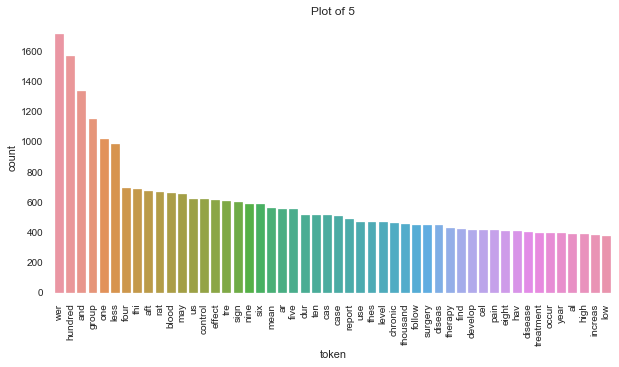

In [42]:
#5. General pathological conditions
plot_most_common_words(key_words_5,"5")

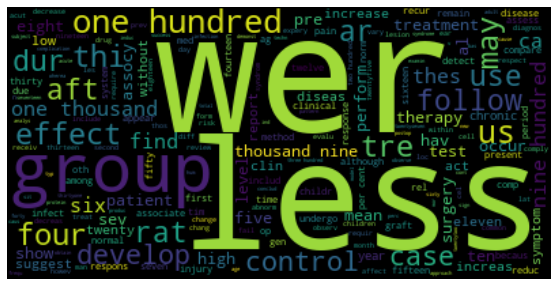

In [43]:
plot_wordcloud(doc5)

In [44]:
key_words_5

{'wer': 1713,
 'hundred': 1568,
 'and': 1332,
 'group': 1149,
 'one': 1014,
 'less': 985,
 'four': 691,
 'thi': 683,
 'aft': 676,
 'rat': 669,
 'blood': 661,
 'may': 654,
 'us': 623,
 'control': 617,
 'effect': 610,
 'tre': 604,
 'sign': 598,
 'nine': 590,
 'six': 589,
 'mean': 558,
 'ar': 555,
 'five': 555,
 'dur': 514,
 'ten': 514,
 'cas': 513,
 'case': 507,
 'report': 487,
 'use': 469,
 'thes': 468,
 'level': 466,
 'chronic': 463,
 'thousand': 454,
 'follow': 447,
 'surgery': 446,
 'diseas': 446,
 'therapy': 428,
 'find': 424,
 'develop': 418,
 'cel': 415,
 'pain': 415,
 'eight': 408,
 'hav': 408,
 'disease': 404,
 'treatment': 396,
 'occur': 395,
 'year': 395,
 'al': 385,
 'high': 385,
 'increas': 382,
 'low': 377}